# Step 1: 載入套件

In [1]:
from __future__ import division
import cv2
import os
import time
import warnings
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import scipy.ndimage as ndi

from skimage import io
from skimage import transform
from skimage.transform import rotate 
from skimage import exposure
from scipy import ndimage
from scipy.signal import butter, lfilter

warnings.filterwarnings('ignore')

# Step 2: 載入圖片，轉灰階

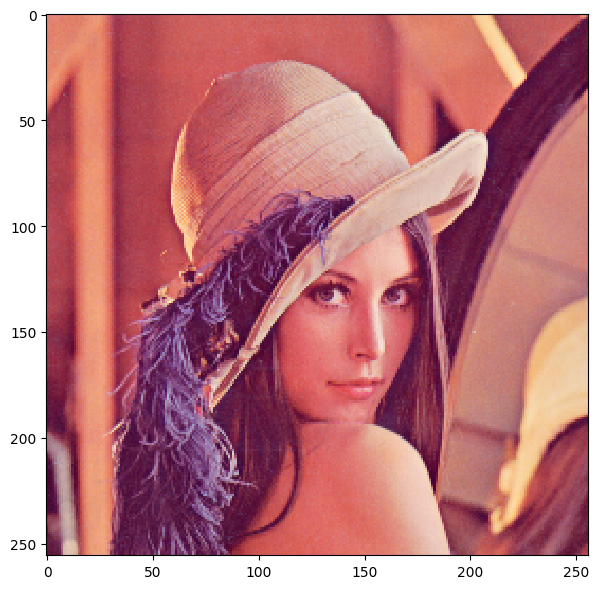

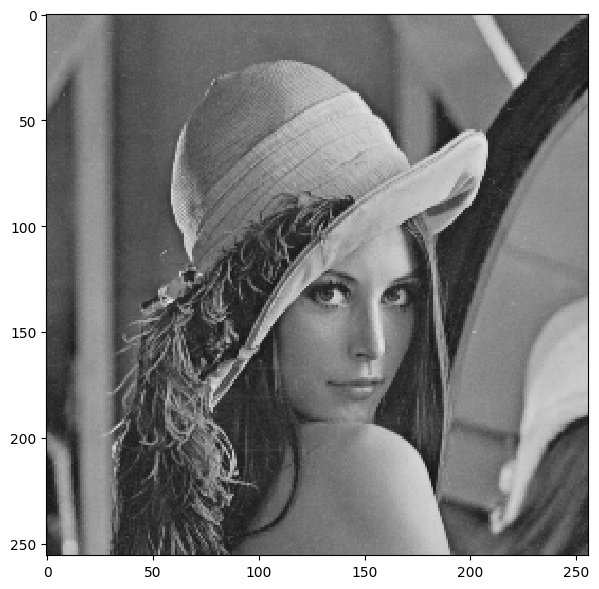

In [2]:
img = io.imread('./source/Pictrue.png')                         # 載入圖片
plt.figure(figsize=(15,6)) 
io.imshow(img)

imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                  # 顯示圖片
plt.figure(figsize=(15,6)) 
io.imshow(imgGray, cmap = 'gray')

# Step 3: 利用FFT對圖片做高斯高通濾波，並測量時間

In [3]:
timeStart = time.time()                                                                                                
# 開始計時，用於記錄程式執行時間。
# `time.time()` 返回當前時間的時間戳（以秒為單位）。

fftImg = np.fft.fftshift(np.fft.fft2(imgGray))                                                                          
# 對灰階影像 `imgGray` 進行二維快速傅立葉變換 (FFT)，轉換到頻率域。
# `np.fft.fft2` 是二維快速傅立葉變換。
# `np.fft.fftshift` 用於將頻率譜的零頻成分移到中心位置，方便視覺化和處理。

fftShiftImg = exposure.rescale_intensity(np.log(1+abs(fftImg)), out_range=(0.0, 1.0))                                    
# 將 FFT 的結果轉換為對數尺度以增強視覺效果。
# `np.log(1+abs(fftImg))` 計算傅立葉變換結果的對數幅值譜（取絕對值以去掉複數部分）。
# `exposure.rescale_intensity` 將強度重新縮放到 0.0 到 1.0 範圍，便於顯示。

array = np.arange(-128, 128)                                                                                             
# 生成從 -128 到 127 的一維陣列，用於構建濾波器的網格座標。

x, y = np.meshgrid(array, array)                                                                                         
# 使用 `np.meshgrid` 將一維陣列轉換為二維網格，`x` 和 `y` 分別是網格中的 X 和 Y 座標。

sigma = 25.0                                                                                                            
# 高斯濾波器的標準差，控制濾波器的寬度。
# 較大的 sigma 對低頻的抑制較少，較小的 sigma 抑制更強。

cutRange = 1.0 - np.exp(-(x**2 + y**2) / sigma**2)                                                                      
# 創建一個高斯高通濾波器的頻率域掩膜。
# `np.exp(-(x**2 + y**2) / sigma**2)` 生成一個二維高斯函數，中心值為 1，越靠近邊緣值越小。
# `1.0 -` 的操作將其轉換為高通濾波器，低頻部分接近 0，高頻部分接近 1。

FourierImg = fftImg * cutRange                                                                                          
# 將高斯高通濾波器應用於傅立葉變換後的影像。
# `fftImg * cutRange` 是點對點相乘，抑制低頻，保留高頻。

timeEnd = time.time()                                                                                                   
# 計算程序結束時的時間戳。

print("Runtime of Using FFT Algorithm in Gaussian High-Pass Filter :", timeEnd - timeStart, "s")                        
# 計算並打印程序運行時間，單位為秒。
# `timeEnd - timeStart` 是總運行時間。

Runtime of Using FFT Algorithm in Gaussian High-Pass Filter : 0.010524272918701172 s


# Step 4:展現結果

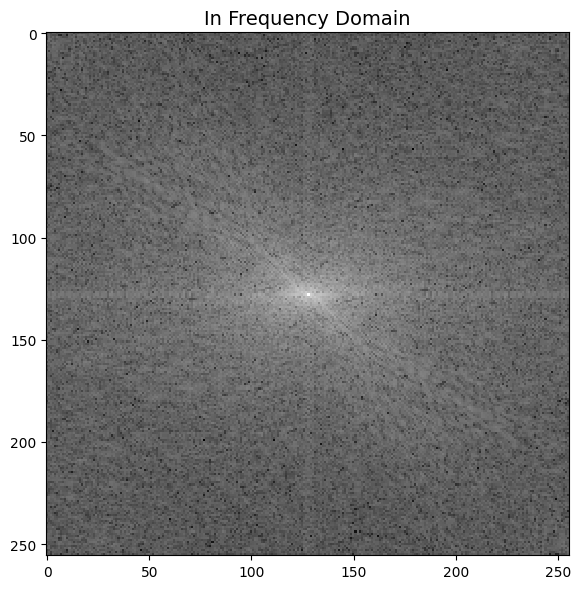

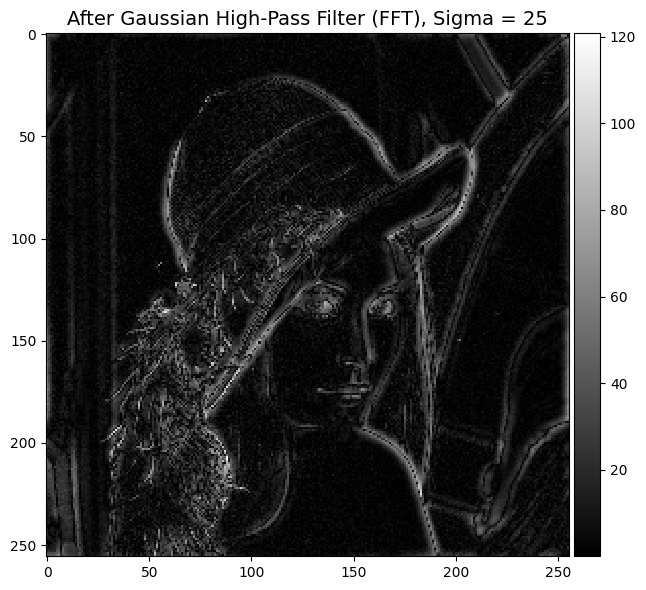

In [4]:
# Plot
plt.figure(figsize=(12,6)) 
plt.title("In Frequency Domain",fontsize = "14")
io.imshow(fftShiftImg)
plt.show()

plt.figure(figsize=(15,6)) 
plt.title("After Gaussian High-Pass Filter (FFT), Sigma = 25",fontsize = "14")
io.imshow(np.abs(np.fft.ifft2(FourierImg)), cmap='gray')
plt.show()

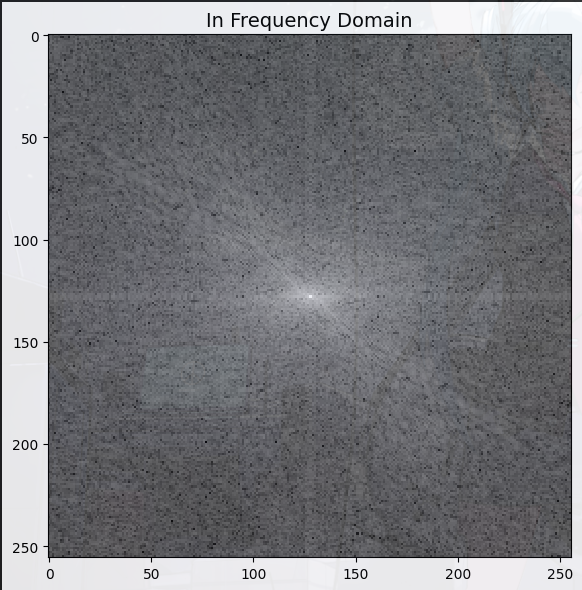<br>
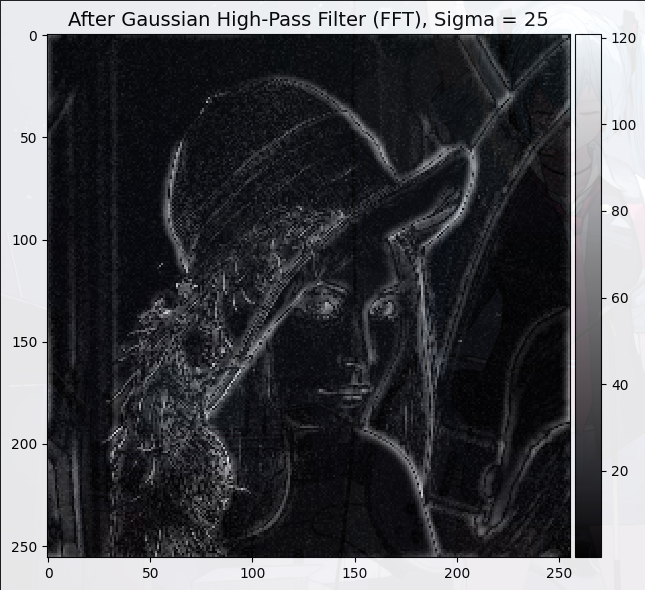

# Step 5: 利用FFT對圖片做Butterworth高通濾波，並測量時間

In [ ]:
timeStart = time.time()
# 開始計時，用於記錄程式執行時間。
# `time.time()` 返回當前時間的時間戳（以秒為單位）。

# Make a Frequency Domain image
fftImg = np.fft.fftshift(np.fft.fft2(imgGray))
# 對灰階影像 `imgGray` 進行二維快速傅立葉變換 (FFT)，轉換到頻率域。
# `np.fft.fft2` 是二維快速傅立葉變換。
# `np.fft.fftshift` 用於將頻率譜的零頻成分移到中心位置，方便視覺化和處理。

fftShiftImg = exposure.rescale_intensity(np.log(1+abs(fftImg)), out_range=(0.0, 1.0))
# 將 FFT 的結果轉換為對數尺度以增強視覺效果。
# `np.log(1+abs(fftImg))` 計算傅立葉變換結果的對數幅值譜（取絕對值以去掉複數部分）。
# `exposure.rescale_intensity` 將強度重新縮放到 0.0 到 1.0 範圍，便於顯示。

# Do Fourier transform to this image
array = np.arange(-128, 128)
# 生成從 -128 到 127 的一維陣列，用於構建濾波器的網格座標。

x, y = np.meshgrid(array, array)
# 使用 `np.meshgrid` 將一維陣列轉換為二維網格，`x` 和 `y` 分別是網格中的 X 和 Y 座標。

D = 25.0
# 設定 Butterworth 濾波器的截止頻率半徑 r。
# 較大的 r 保留更多的低頻，較小的 r 抑制更多低頻。

cutRange = 1 - 1.0 / (1.0 + ((x**2 + y**2) / D**2)**2)
# 創建一個 Butterworth 高通濾波器的頻率域掩膜。
# `((x**2 + y**2) / D**2)**2` 是二階 Butterworth 濾波器的公式，控制濾波器的過渡區域。
# `1.0 / (1.0 + ...)` 生成一個低通濾波器。
# `1 - ...` 將低通濾波器轉換為高通濾波器。

FourierImg = fftImg * cutRange
# 將 Butterworth 高通濾波器應用於傅立葉變換後的影像。
# `fftImg * cutRange` 是點對點相乘，抑制低頻，保留高頻。

timeEnd = time.time()
# 計算程序結束時的時間戳。

print("Runtime of Using FFT Algorithm in ButterWorth High-Pass Filter :", timeEnd - timeStart, "s")
# 計算並打印程序運行時間，單位為秒。
# `timeEnd - timeStart` 是總運行時間。

Runtime of Using FFT Algorithm in ButterWorth High-Pass Filter : 0.010521173477172852 s


# Step 6:展現結果

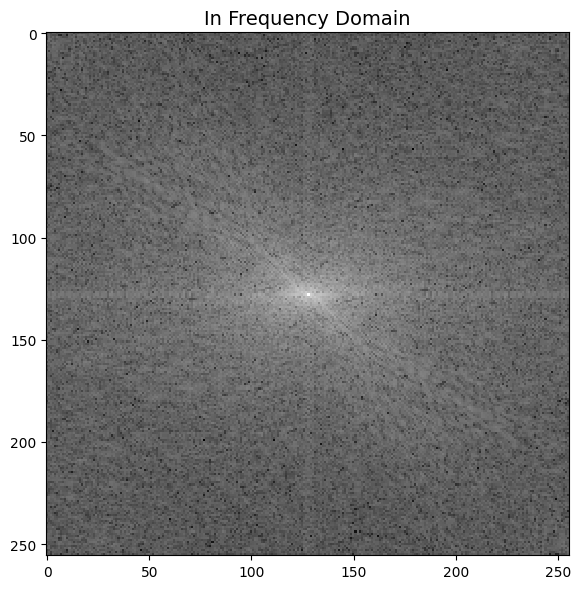

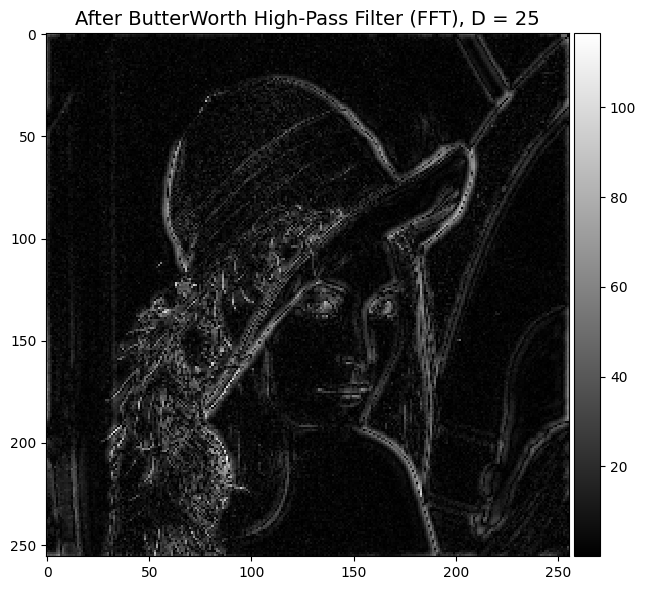

In [6]:
plt.figure(figsize=(12,6))                                                              # 顯示圖片
plt.title("In Frequency Domain",fontsize = "14")
io.imshow(fftShiftImg)
plt.show()

plt.figure(figsize=(15,6)) 
plt.title("After ButterWorth High-Pass Filter (FFT), D = 25",fontsize = "14")
io.imshow(np.abs(np.fft.ifft2(FourierImg)), cmap='gray')
plt.show()

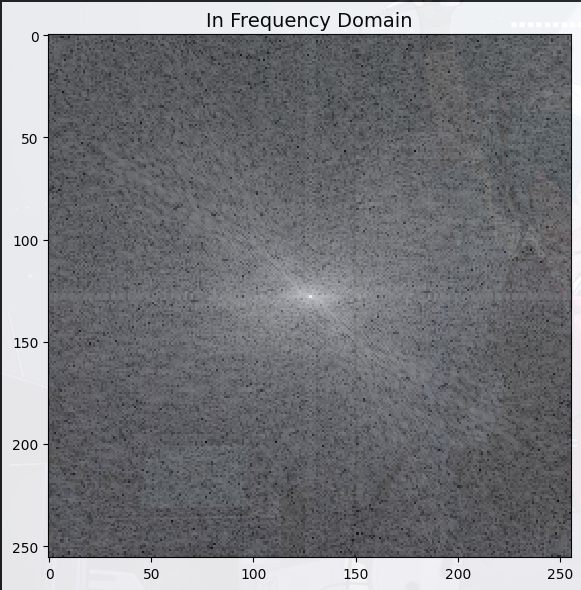<br>
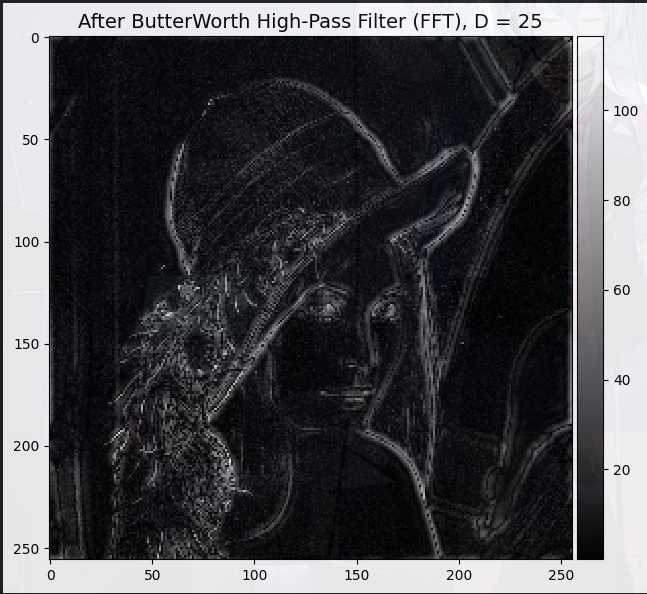

# 心得：
&emsp;&emsp;透過此次的實驗，我更清楚瞭解到高通濾波器的特性，而透過兩高通濾波器的比較，我也清楚得知如果需要平滑過渡和不需要明確截止頻率的應用，建議使用 Gaussian 高通濾波器，如果需要更明確的頻率分離和靈活的截止頻率控制，建議使用 Butterworth 高通濾波器。